You are looking at data from an e-commerce website. The site is very simple and has just 4 pages:

The ﬁrst page is the home page. When you come to the site for the ﬁrst time, you can only land on the home page as a ﬁrst page.
From the home page, the user can perform a search and land on the search page.
From the search page, if the user clicks on a product, she will get to the payment page, where she is asked to provide payment information in order to buy that product.
If she does decide to buy, she ends up on the conﬁrmation page

In [5]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
plt.style.use('ggplot')
%matplotlib inline

In [6]:
alluser  = pd.read_csv('home_page_table.csv',index_col= 'user_id')
users_to_search = pd.read_csv('search_page_table.csv',index_col = 'user_id')
users_to_pay = pd.read_csv('payment_page_table.csv',index_col = 'user_id')
users_to_confirm = pd.read_csv('payment_confirmation_table.csv',index_col = 'user_id')

(452, 1)

replace the page in 'alluser' as the final page state of each user


In [7]:
alluser.loc[users_to_search.index,"page"] = users_to_search.page
alluser.loc[users_to_pay.index,'page']= users_to_pay.page
alluser.loc[users_to_confirm.index,'page'] = users_to_confirm.page
alluser.rename(columns = {'page':'final_page'},inplace = True)
print (alluser.final_page.value_counts())
print (alluser.isnull().sum())

home_page                    45200
search_page                  39170
payment_page                  5578
payment_confirmation_page      452
Name: final_page, dtype: int64
final_page    0
dtype: int64


/Users/xiaoyisun/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


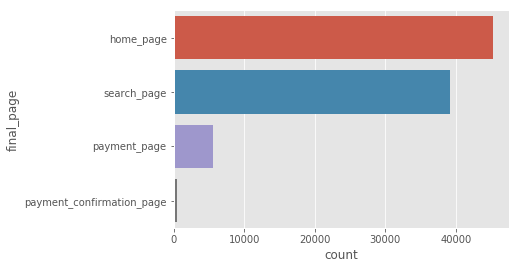

In [8]:
sns.countplot(y='final_page',data=alluser)
plt.show()

In [9]:
pages = ['home_page','search_page','payment_page','payment_confirmation_page']
alluser["final_page"] = alluser.final_page.astype("category",categories = pages,ordered=True)

/Users/xiaoyisun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


home_page                    45200
search_page                  39170
payment_page                  5578
payment_confirmation_page      452
Name: final_page, dtype: int64

In [27]:
users_infos = pd.read_csv('user_table.csv',index_col='user_id')
users_infos.shape

(90400, 3)

In [11]:
alluser = alluser.join(users_infos)
alluser.isnull().sum()

final_page    0
date          0
device        0
sex           0
dtype: int64

In [12]:
alluser['date'] = pd.to_datetime(alluser.date)
alluser.head(10)

,final_page,date,device,sex
user_id,,,,
313593,home_page,2015-02-26,Desktop,Female
468315,home_page,2015-02-21,Desktop,Male
264005,home_page,2015-03-25,Desktop,Female
290784,home_page,2015-03-14,Desktop,Male
639104,search_page,2015-01-03,Desktop,Female
262889,home_page,2015-01-10,Mobile,Male
708793,home_page,2015-04-24,Mobile,Female
943143,search_page,2015-04-10,Desktop,Male
417894,home_page,2015-04-02,Mobile,Female


In this section, the conversion function is built to calculate the conversion between pages

In [13]:

def convert_ratio(df):
    pages_count = df.final_page.value_counts()
    convert_count = pages_count.copy()
    
    total = df.shape[0]
    for page in pages_count.index:
        count_left = pages_count.loc[page] # count the number of people left after reviwing this page
        convert_count[page] = total-count_left # count the number of people convert to the next page
        total = total-count_left
    cr = pd.concat([pages_count,convert_count],axis = 1,keys = ['n_left','n_convert'])
    cr['convert_rate'] = cr.n_convert.astype(np.float)/(cr.n_convert+cr.n_left)
    cr['left_rate'] = 1-cr.convert_rate
    
    return cr

In [14]:
alluser.groupby('device').apply(convert_ratio)


n_left  n_convert  convert_rate  left_rate
device                                                                       
Desktop home_page                   30100      30100      0.500000   0.500000
        search_page                 27090       3010      0.100000   0.900000
        payment_page                 2860        150      0.049834   0.950166
        payment_confirmation_page     150          0      0.000000   1.000000
Mobile  home_page                   15100      15100      0.500000   0.500000
        search_page                 12080       3020      0.200000   0.800000
        payment_page                 2718        302      0.100000   0.900000
        payment_confirmation_page     302          0      0.000000   1.000000

In [15]:
alluser.groupby('device')['final_page'].apply(lambda x: x.value_counts(normalize = True)).unstack()

,home_page,search_page,payment_page,payment_confirmation_page
device,,,,
Desktop,0.5,0.45,0.047508,0.002492
Mobile,0.5,0.40,0.090000,0.010000


This part focus on the discussion of what the product team should focus on in order to improve conversion rate as well as anything you might discover that could help improve conversion rate.

In [16]:
alluser.head(1)
X = alluser.copy()
X.head()

,final_page,date,device,sex
user_id,,,,
313593,home_page,2015-02-26,Desktop,Female
468315,home_page,2015-02-21,Desktop,Male
264005,home_page,2015-03-25,Desktop,Female
290784,home_page,2015-03-14,Desktop,Male
639104,search_page,2015-01-03,Desktop,Female


In [17]:
X = pd.get_dummies(X,columns=['device','sex'])
X.head(10)

,final_page,date,device_Desktop,device_Mobile,sex_Female,sex_Male
user_id,,,,,,
313593,home_page,2015-02-26,1,0,1,0
468315,home_page,2015-02-21,1,0,0,1
264005,home_page,2015-03-25,1,0,1,0
290784,home_page,2015-03-14,1,0,0,1
639104,search_page,2015-01-03,1,0,1,0
262889,home_page,2015-01-10,0,1,0,1
708793,home_page,2015-04-24,0,1,1,0
943143,search_page,2015-04-10,1,0,0,1
417894,home_page,2015-04-02,0,1,1,0


In [18]:
X.rename(columns = {'device_Desktop':'Desktop','device_Mobile':'Mobile','sex_Female':'Female','sex_Male':'Male'},inplace=True)
X.head(10)

,final_page,date,Desktop,Mobile,Female,Male
user_id,,,,,,
313593,home_page,2015-02-26,1,0,1,0
468315,home_page,2015-02-21,1,0,0,1
264005,home_page,2015-03-25,1,0,1,0
290784,home_page,2015-03-14,1,0,0,1
639104,search_page,2015-01-03,1,0,1,0
262889,home_page,2015-01-10,0,1,0,1
708793,home_page,2015-04-24,0,1,1,0
943143,search_page,2015-04-10,1,0,0,1
417894,home_page,2015-04-02,0,1,1,0


In [19]:
X['converted'] = (X.final_page == 'payment_confirmation_page').astype(int)
del X['final_page']
X.converted.mean()

0.005

In [20]:
X.groupby('Male')['converted'].agg(['count','mean']).sort_values(by='mean',ascending=False)

,count,mean
Male,,
0,45075,0.005347
1,45325,0.004655


In [21]:
X['weekday'] = X.date.dt.weekday_name
del X['date']

Impact of date

In [22]:
X.groupby('weekday')['converted'].agg(['count','mean']).sort_values(by='mean',ascending=False)

,count,mean
weekday,,
Monday,12955,0.005944
Saturday,12801,0.005468
Tuesday,12697,0.005434
Thursday,13444,0.004909
Sunday,12922,0.004798
Friday,12750,0.004235
Wednesday,12831,0.004209


In [23]:
X = pd.get_dummies(X,columns=['weekday'])
X.head(10)

,Desktop,Mobile,Female,Male,converted,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
user_id,,,,,,,,,,,,
313593,1,0,1,0,0,0,0,0,0,1,0,0
468315,1,0,0,1,0,0,0,1,0,0,0,0
264005,1,0,1,0,0,0,0,0,0,0,0,1
290784,1,0,0,1,0,0,0,1,0,0,0,0
639104,1,0,1,0,0,0,0,1,0,0,0,0
262889,0,1,0,1,0,0,0,1,0,0,0,0
708793,0,1,1,0,0,1,0,0,0,0,0,0
943143,1,0,0,1,0,1,0,0,0,0,0,0
417894,0,1,1,0,0,0,0,0,0,1,0,0


In [24]:
y = X.converted
X = X.loc[:,X.columns != 'converted']


In [25]:
from sklearn.feature_selection import chi2
scores, pvalues = chi2(X,y)
pd.DataFrame({'chi2_score':scores,'chi2_pvalue':pvalues},index=X.columns).sort_values(by='chi2_score',ascending=False)

,chi2_score,chi2_pvalue
Mobile,151.758794,7.153913e-35
Desktop,76.131488,2.653915e-18
weekday_Monday,2.318821,1.278169e-01
weekday_Wednesday,1.615497,2.037208e-01
weekday_Friday,1.498670,2.208761e-01
Female,1.088708,2.967578e-01
Male,1.082703,2.980938e-01
weekday_Saturday,0.564341,4.525166e-01
weekday_Tuesday,0.481501,4.877434e-01
weekday_Sunday,0.105964,7.447867e-01


In [33]:
dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=20,min_samples_split=20)
dt.fit(X,y)
export_graphviz(dt,out_file="mytree.dot",feature_names=X.columns,class_names=['NotConvert','Converted'],
                proportion=True,leaves_parallel=True,filled=True)


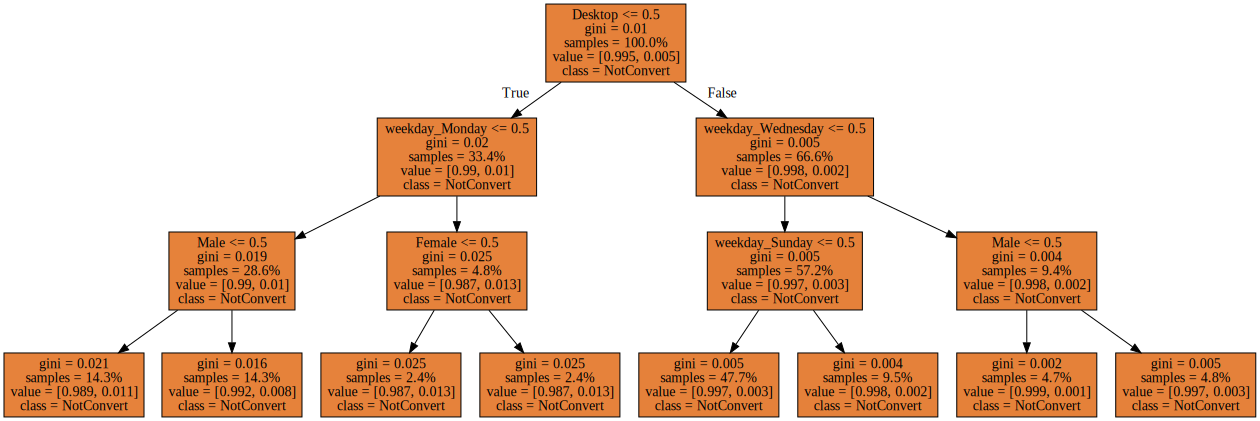

In [1]:
import graphviz
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)